<a href="https://colab.research.google.com/github/Pompey21/Don-t-Let-the-Bark-Beetle-Bite-You/blob/main/parameter_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######## INSTALATION
!pip install sentinelhub
!pip install s2cloudless
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import files
from google.colab import drive
from PIL import Image
import datetime as dt
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, \
    MimeType, bbox_to_dimensions
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest, get_s2_evalscript


In [ ]:


def plot_image(image=None, mask=None, ax=None, factor=3.5/255, clip_range=(0, 1), **kwargs):
    """ Utility function for plotting RGB images and masks.
    """
    print(f'Image: {image}')
    print(f'Mask: {mask}')
    print(type(mask))
    print(mask.shape)
    print(mask.ndim)
    print(f'Ax: {ax}')

    np.savetxt('array.csv', mask, delimiter=',', fmt='%d')





    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

    plt.title("Region of Interest - True Colour",fontsize=30)
    mask_color = [255, 255, 255, 255] if image is None else [255, 255, 0, 100]
    

    if image is None:
        if mask is None:
            raise ValueError('image or mask should be given')
        image = np.zeros(mask.shape + (3,), dtype=np.uint8)

    ax.imshow(np.clip(image * factor, *clip_range), **kwargs)

    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

        cloud_image[mask == 1] = np.asarray(mask_color, dtype=np.uint8)
        plt.title("Region of Interest - Cloud Mask",fontsize=30)
        plt.xticks([])
        plt.yticks([])
        ax.imshow(cloud_image)

%reload_ext autoreload
%autoreload 2
%matplotlib inline



# setting configuration information to access data from the ScienceHub
config = SHConfig()

config.instance_id = 'c7b45463-8ad6-483e-b775-b1a561cca401'
config.sh_client_id = '766f8ea6-160f-4351-ad48-06058abbd590'
config.sh_client_secret = 'z^{3w^zz%lrq^;rf-7T:Anu!@[8pJ]_O<*2-NRn9'

config.save()

# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = ''
CLIENT_SECRET = ''

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

# coordinates of the region
bbox = BBox([14.48200,45.54980,14.54738,45.59538], crs=CRS.WGS84)

evalscript = get_s2_evalscript(
    all_bands=False,
    reflectance=True
)

print(evalscript)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval='2016-08-14'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=(1152,1132),
    config=config
)

data = request.get_data()[0]

bands = data[..., :-1]
mask = data[..., -1]

bands.shape, mask.shape

//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B01", "B02", "B04", "B05", "B08", "B8A", "B09", "B10", "B11", "B12", "dataMask"],
      units: "reflectance"
    }],
    output: {
      bands: 11,
      sampleType: "FLOAT32"
    }
  };
}

function evaluatePixel(sample) {
  return [sample.B01, sample.B02, sample.B04, sample.B05, sample.B08, sample.B8A, sample.B09, sample.B10, sample.B11, sample.B12, sample.dataMask];
}


((1132, 1152, 10), (1132, 1152))

In [ ]:
treshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
all_bands = [True, False]
average_over = [1,2,3,4,5,6,7,8]
dilation_size = [1,2,3,4,5,6,7,8]
collection = [treshold,all_bands,average_over,dilation_size]

import itertools

combinations = list(itertools.product(*collection))

print(len(combinations))

import random
random_nums = [random.randint(0, 1280) for i in range(20)]
print(random_nums)
chosen_combinations = [combinations[index] for index in random_nums]
print(chosen_combinations)

1280
[109, 513, 1170, 789, 581, 327, 922, 830, 612, 14, 850, 824, 1197, 1111, 637, 838, 781, 1207, 1099, 694]
[(0.1, False, 6, 6), (0.5, True, 1, 2), (1, True, 3, 3), (0.7, True, 3, 6), (0.5, False, 1, 6), (0.3, False, 1, 8), (0.8, True, 4, 3), (0.7, True, 8, 7), (0.5, False, 5, 5), (0.1, True, 2, 7), (0.7, False, 3, 3), (0.7, True, 8, 1), (1, True, 6, 6), (0.9, False, 3, 8), (0.5, False, 8, 6), (0.7, False, 1, 7), (0.7, True, 2, 6), (1, True, 7, 8), (0.9, False, 2, 4), (0.6, True, 7, 7)]


In [ ]:
# CLOUD DETECTOR PARAMETRS
cloud_detector = S2PixelCloudDetector(
    threshold=0.2,
    average_over=4,
    dilation_size=2,
    all_bands=False
)


cloud_prob = cloud_detector.get_cloud_probability_maps(bands)


cloud_mask = cloud_detector.get_cloud_masks(bands)

# plot_image(mask=cloud_mask)

In [ ]:
# drive.mount('/content/gdrive')

def param_tunning_automated(chosen_combinations:list):
  print('Initialising...')
  for count,params in enumerate(chosen_combinations):
    # print(f'Threshold: {params[0]}')
    # print(f'Average_Over: {params[1]}')
    # print(f'Dilation_Size: {params[2]}')
    print(f'Testing Model {count}')
    cloud_detector = S2PixelCloudDetector(
    threshold=params[0],
    average_over=params[1],
    dilation_size=params[2],
    all_bands=True 
    )
    cloud_prob = cloud_detector.get_cloud_probability_maps(bands)
    cloud_mask = cloud_detector.get_cloud_masks(bands)
    plot_image(mask=cloud_mask)

    file_name = 'model_'+str(count)+'.csv'
    np.savetxt(file_name, cloud_mask, delimiter=',', fmt='%d')


Initialising...
Testing Model 0
Image: None
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(1132, 1152)
2
Ax: None
Testing Model 1
Image: None
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(1132, 1152)
2
Ax: None
Testing Model 2
Image: None
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(1132, 1152)
2
Ax: None
Testing Model 3
Image: None
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(1132, 1152)
2
Ax: None
Testing Model 4
Image: None
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'

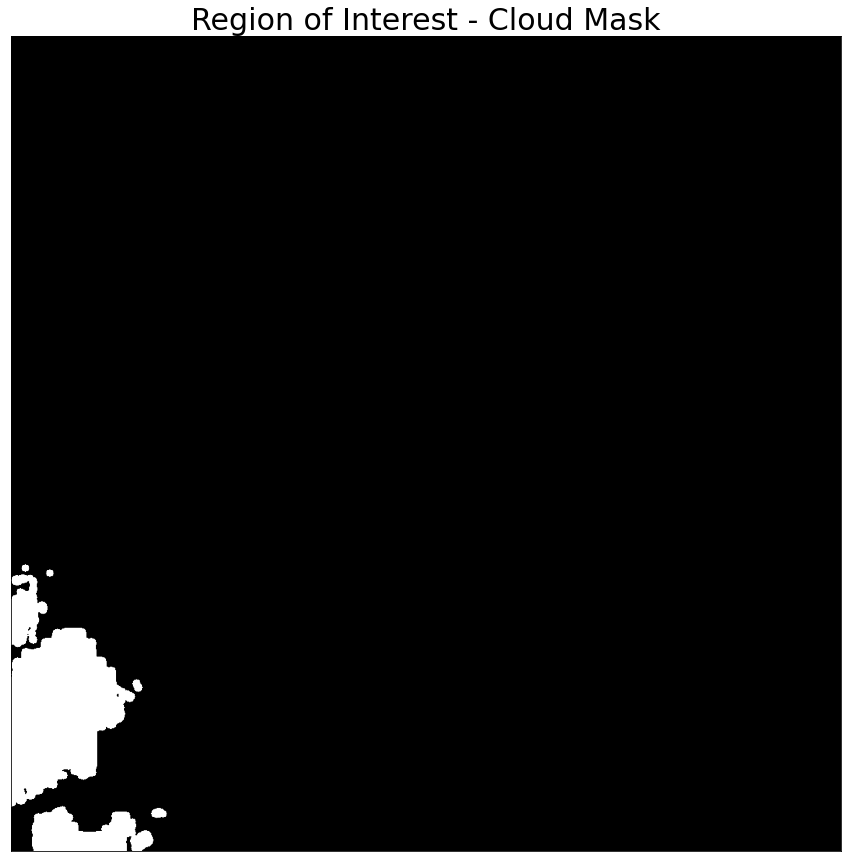

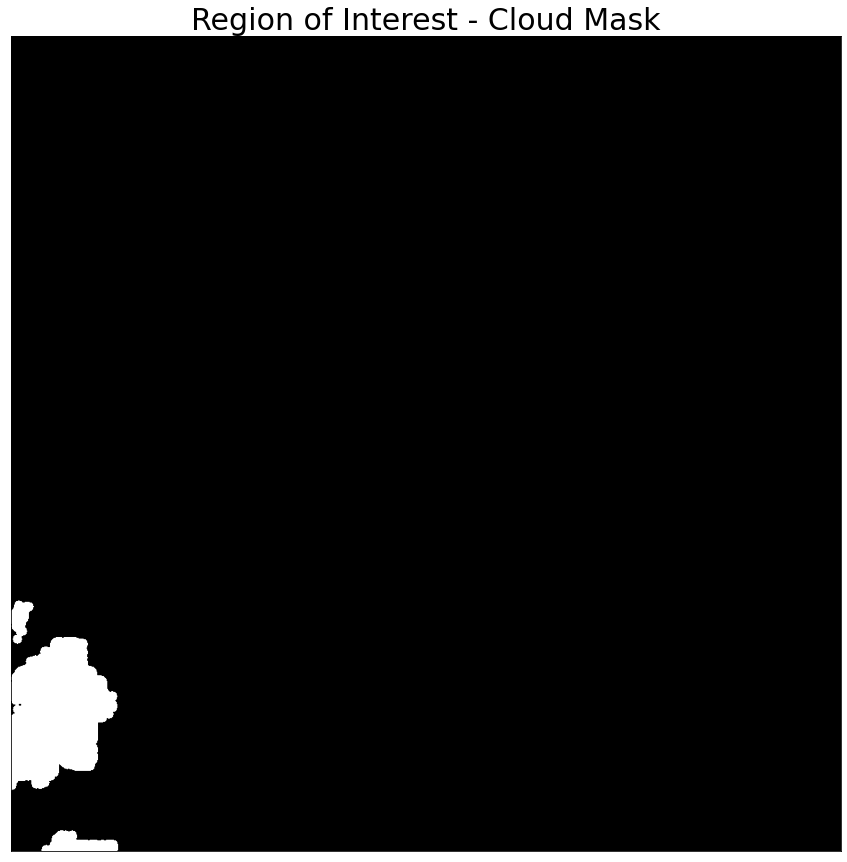

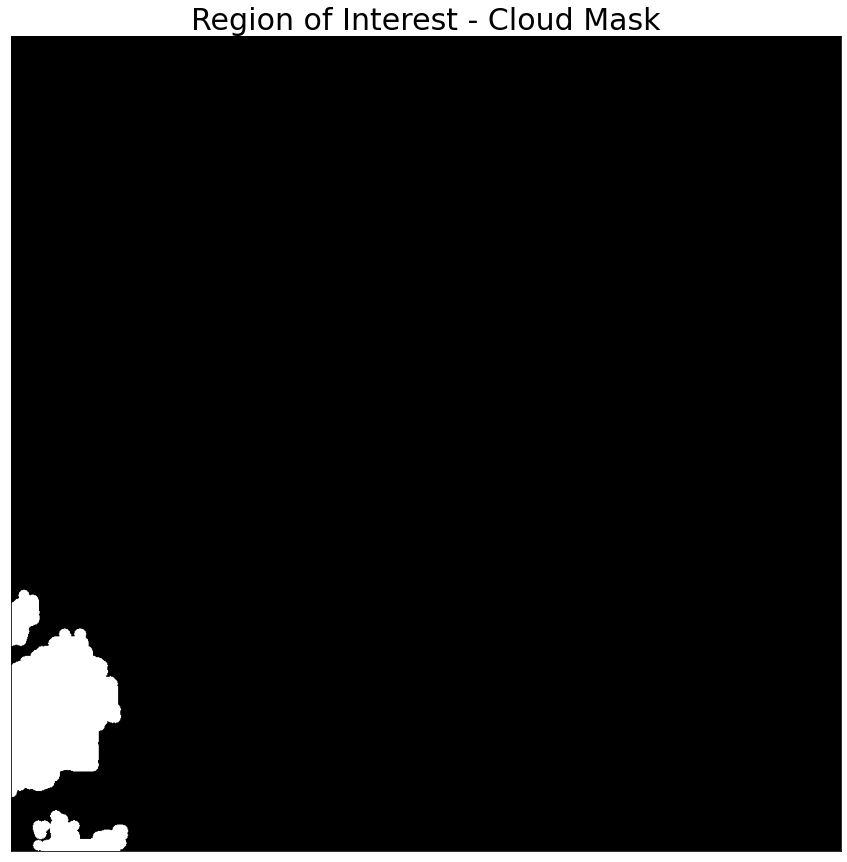

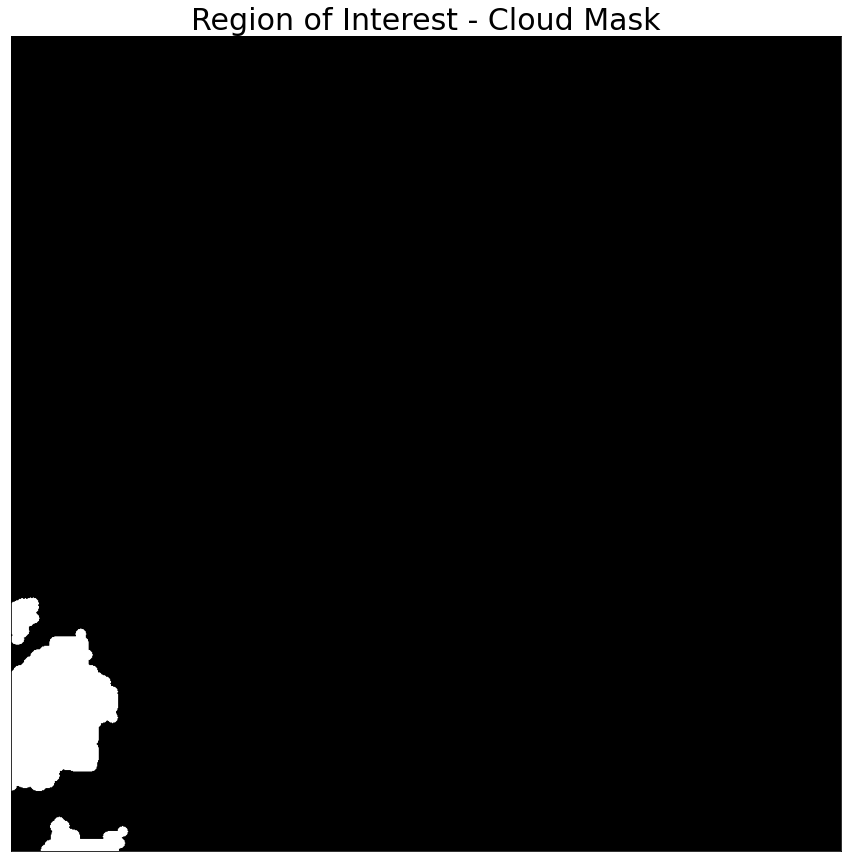

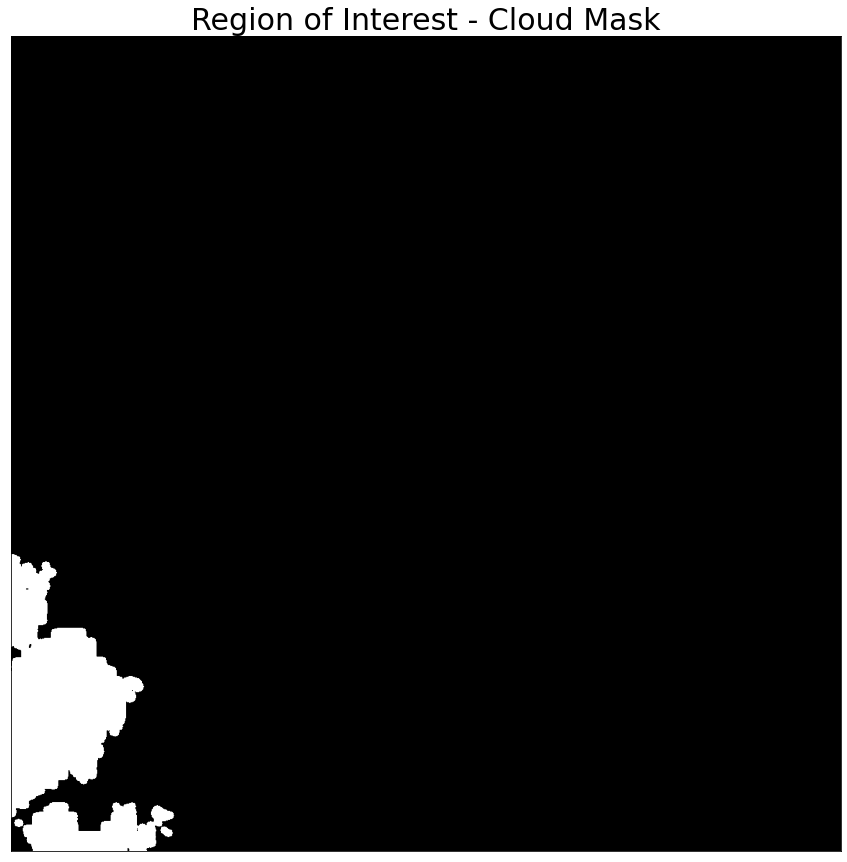

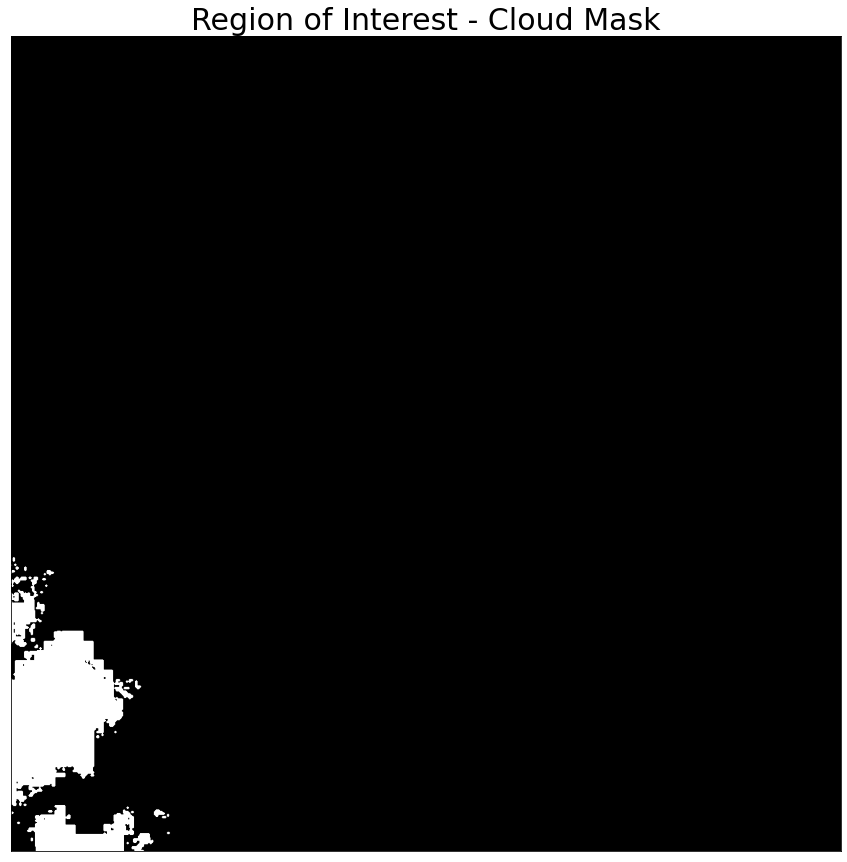

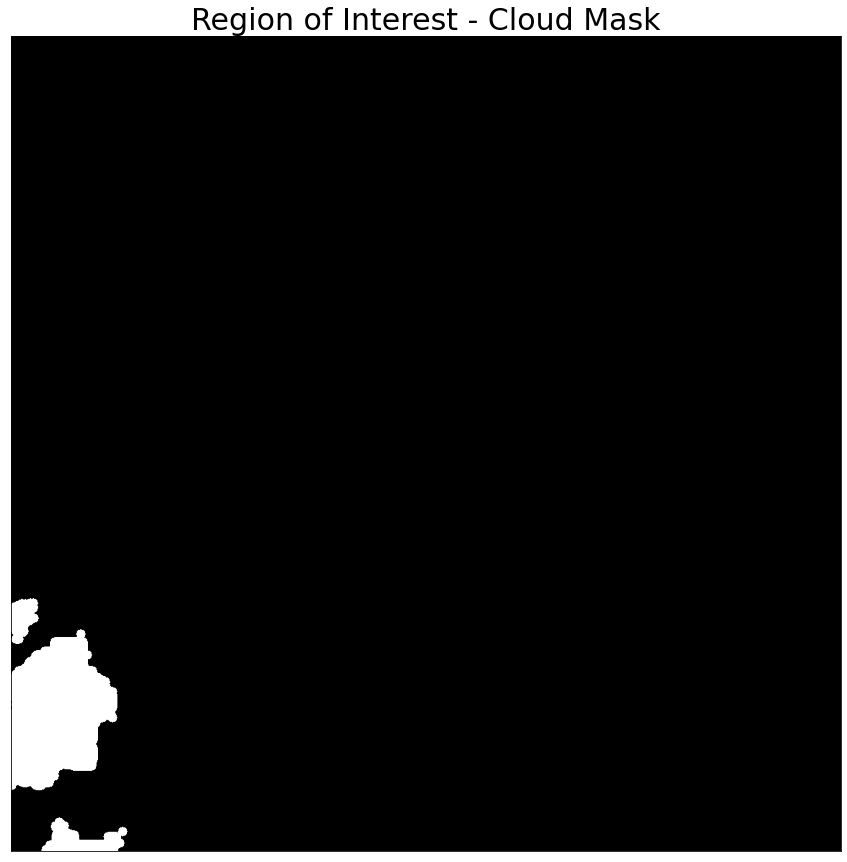

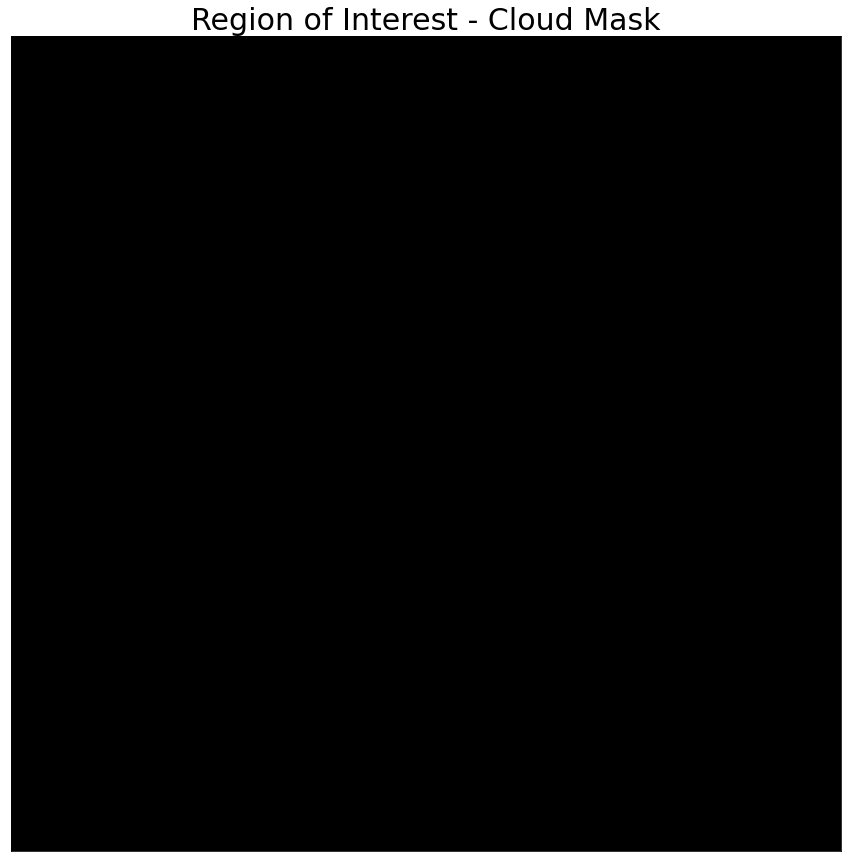

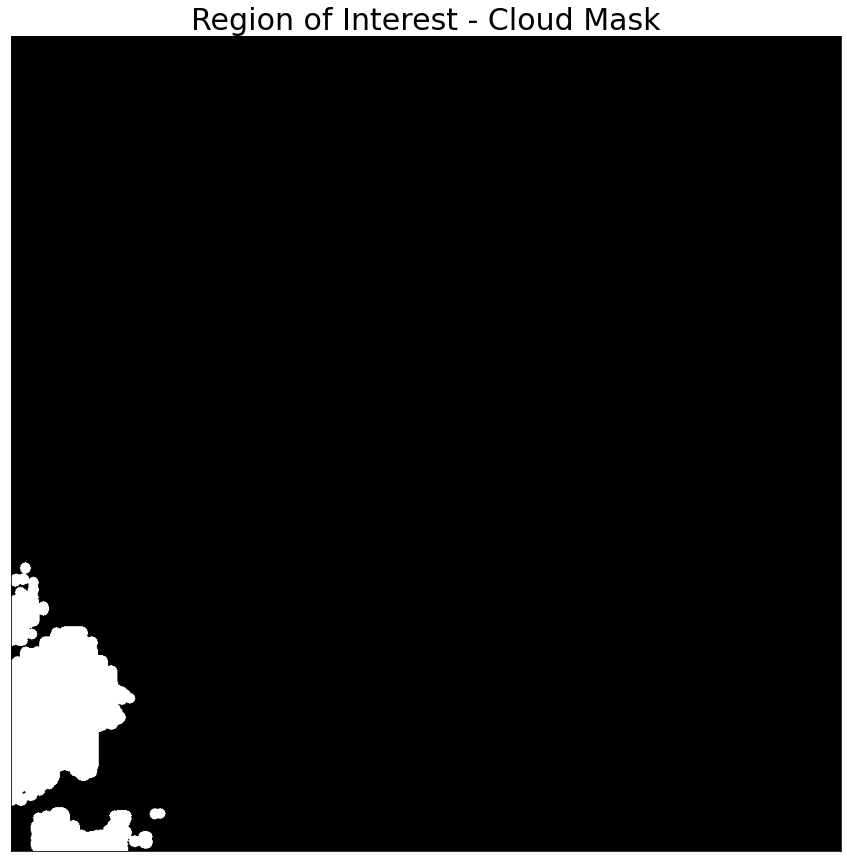

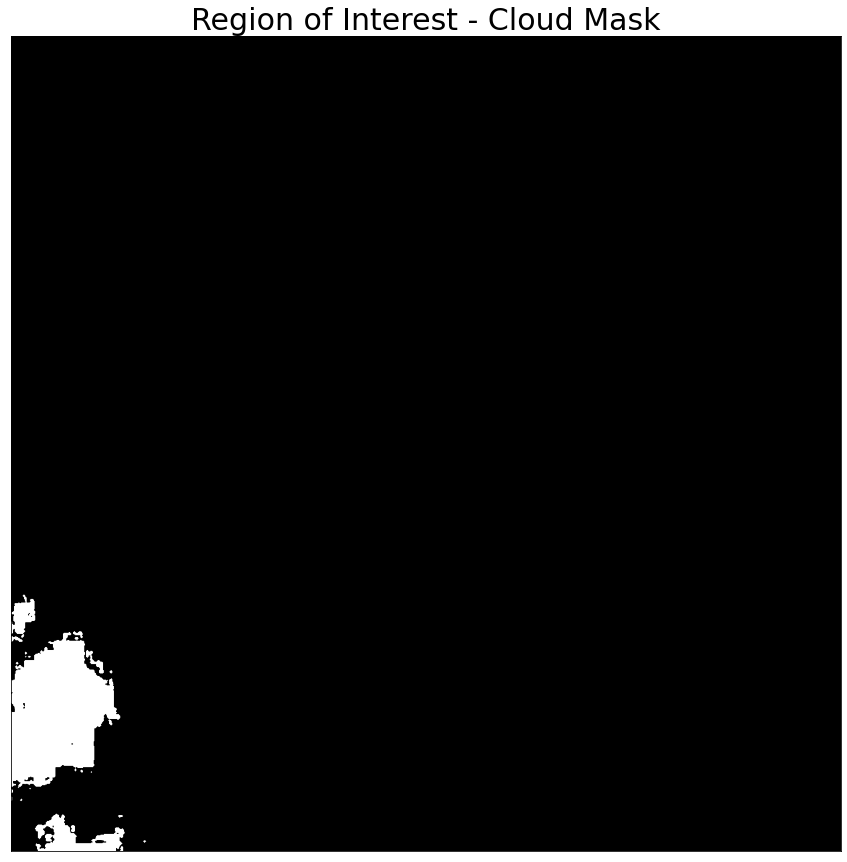

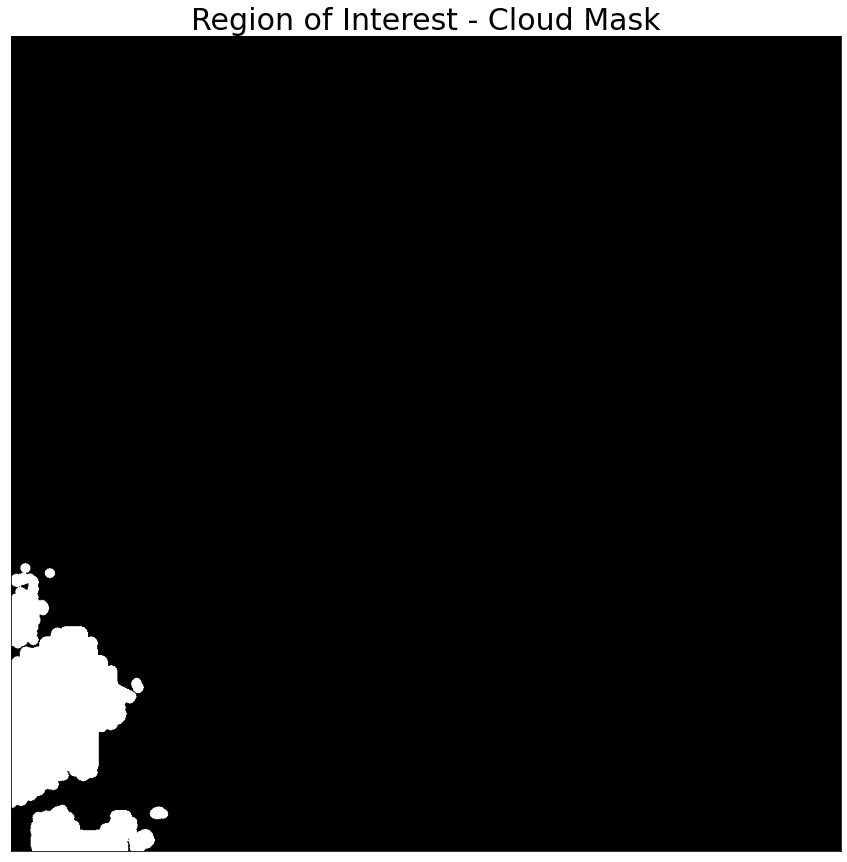

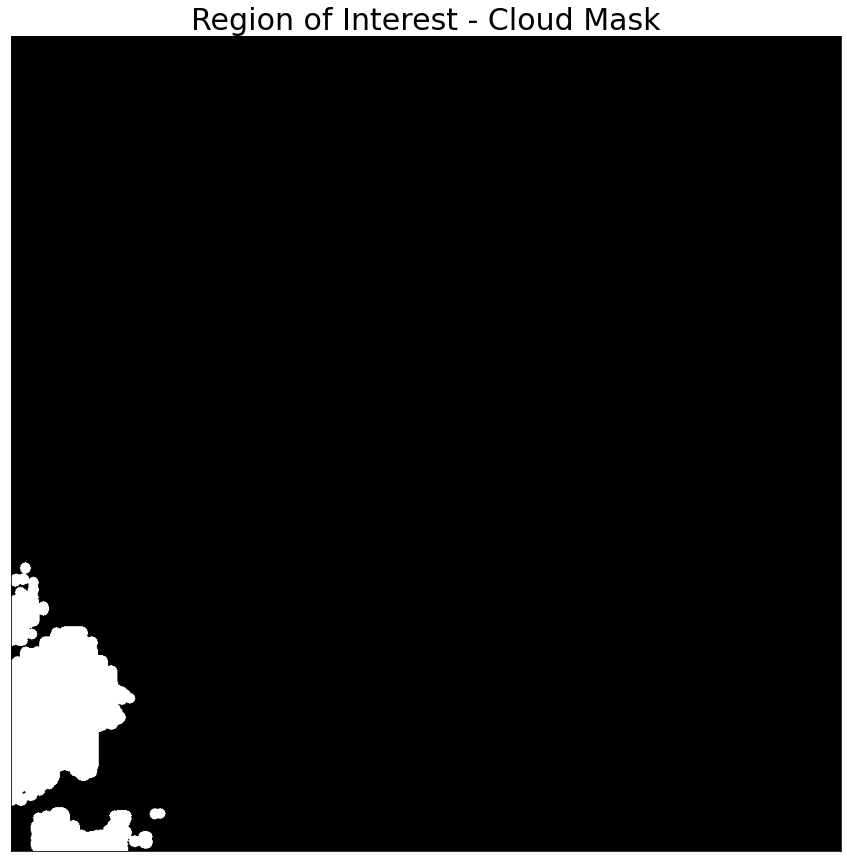

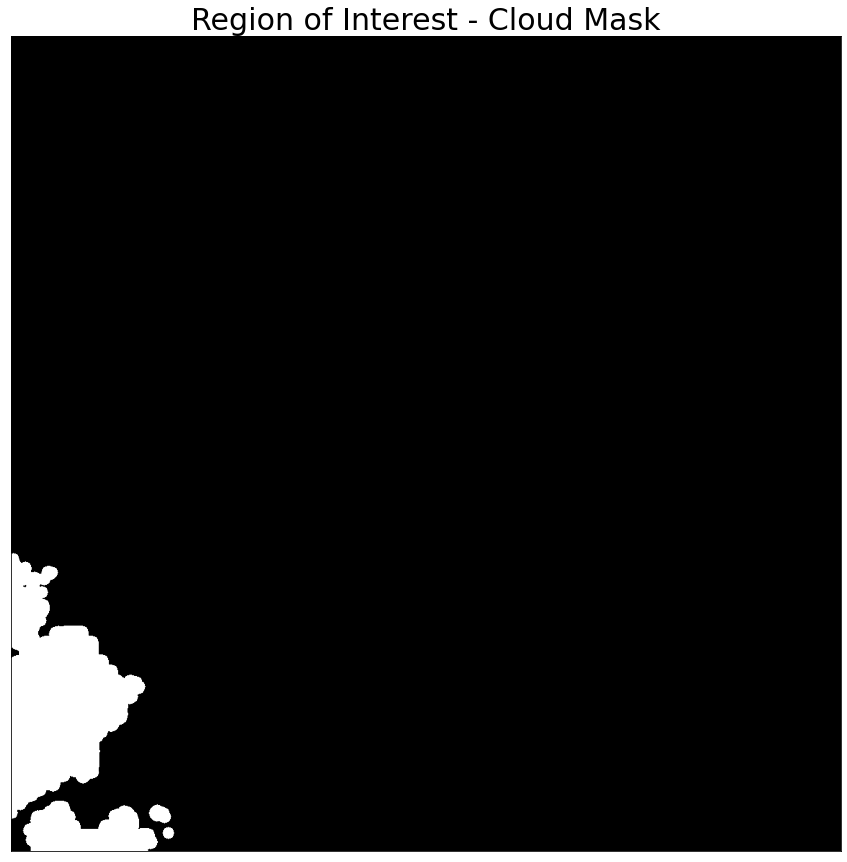

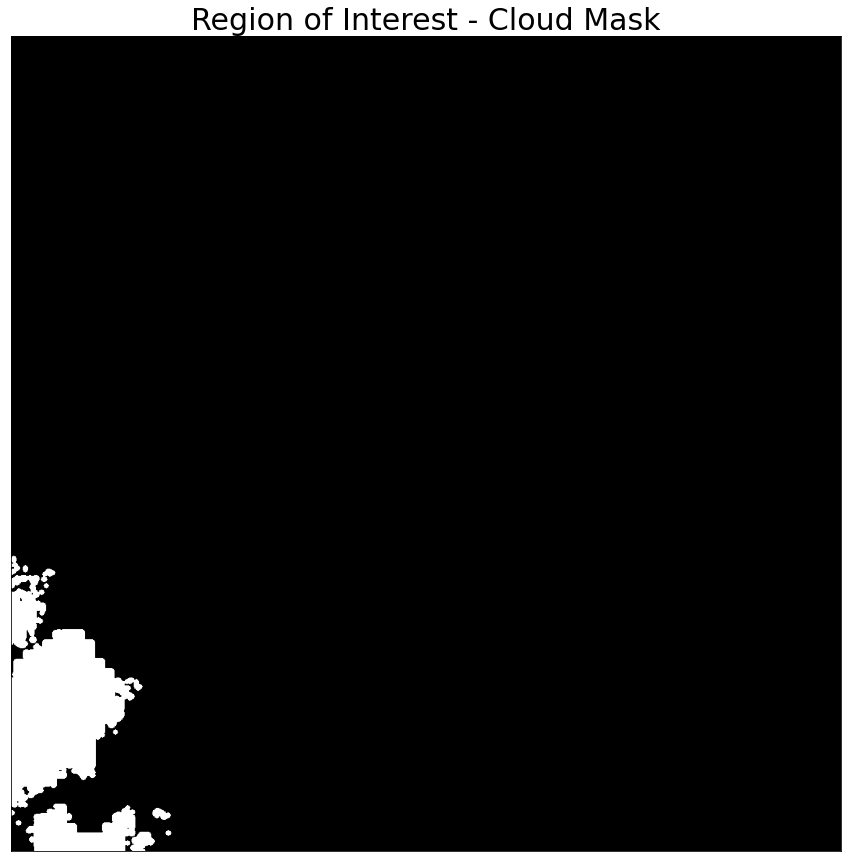

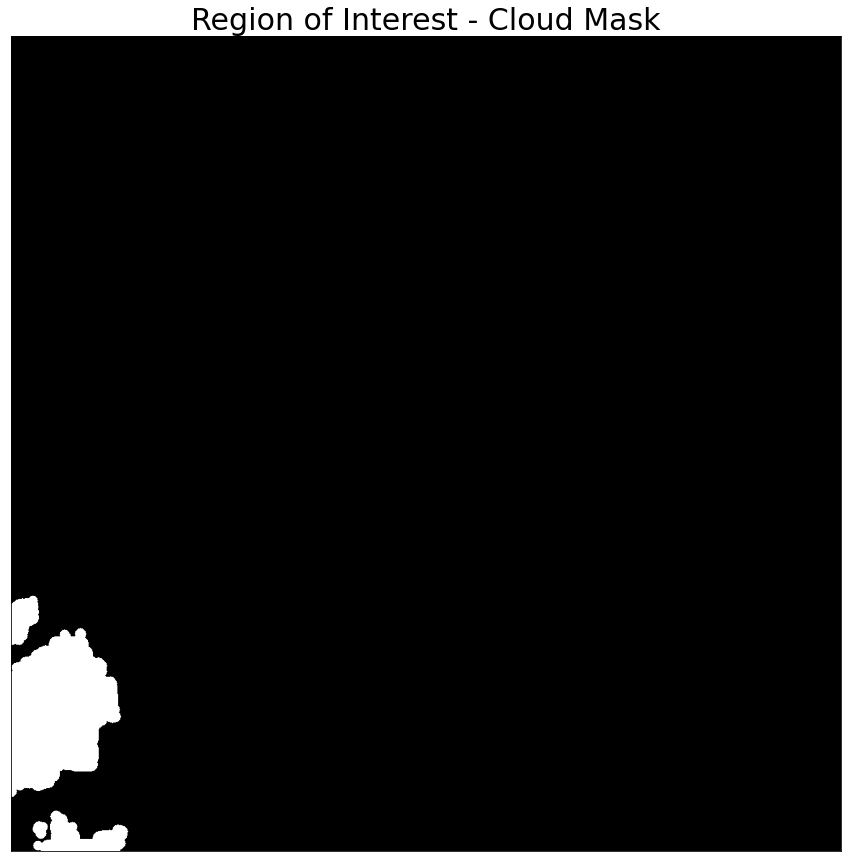

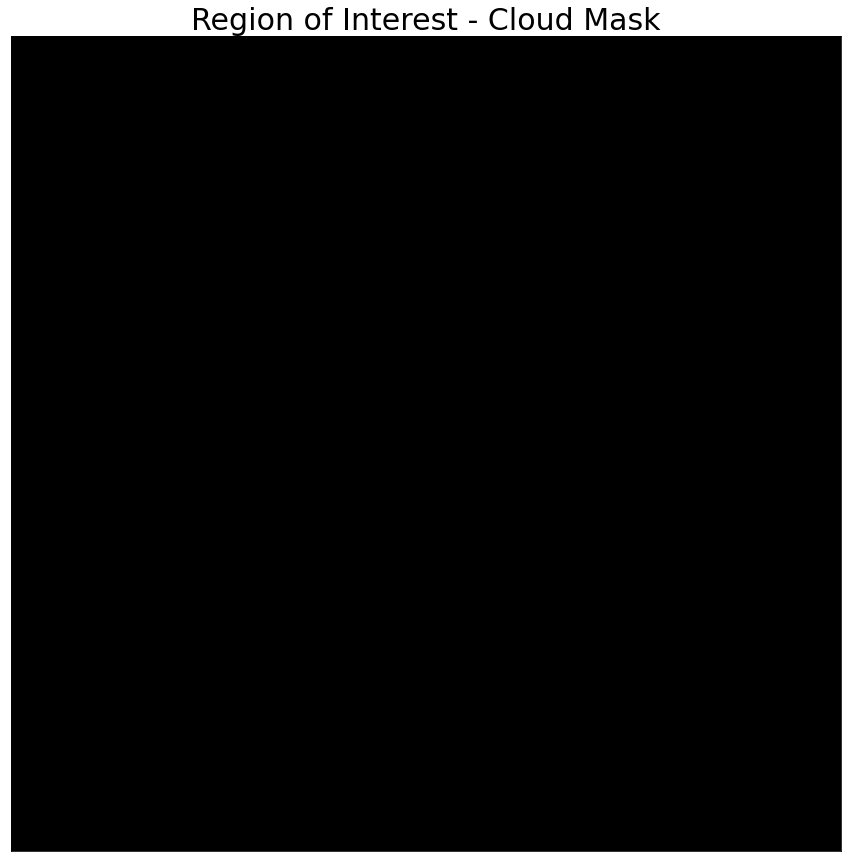

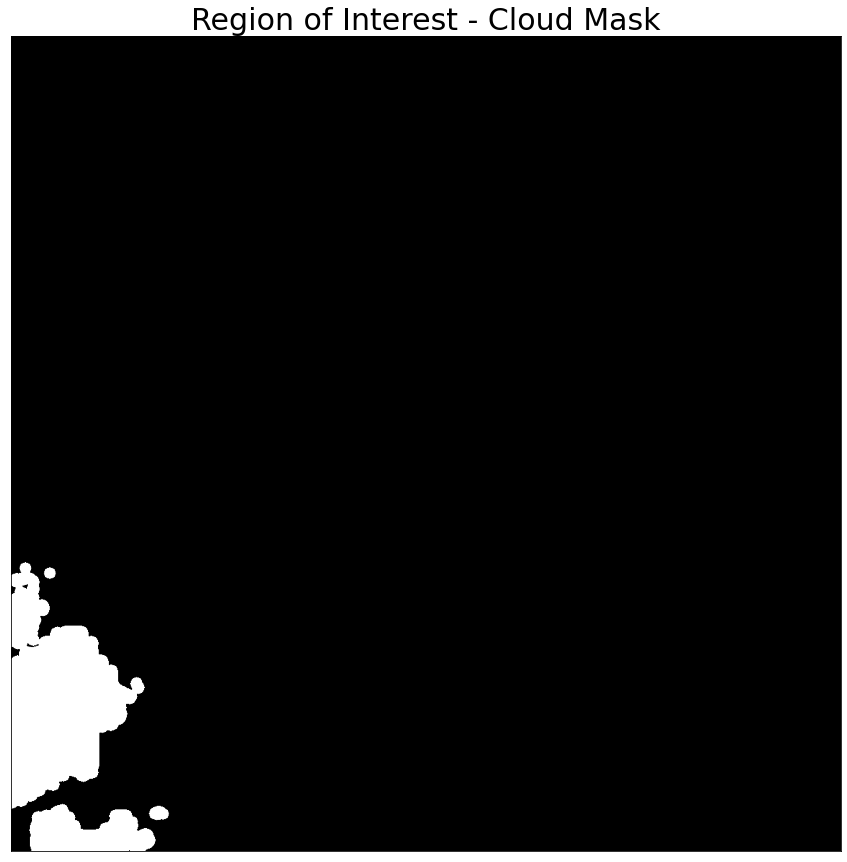

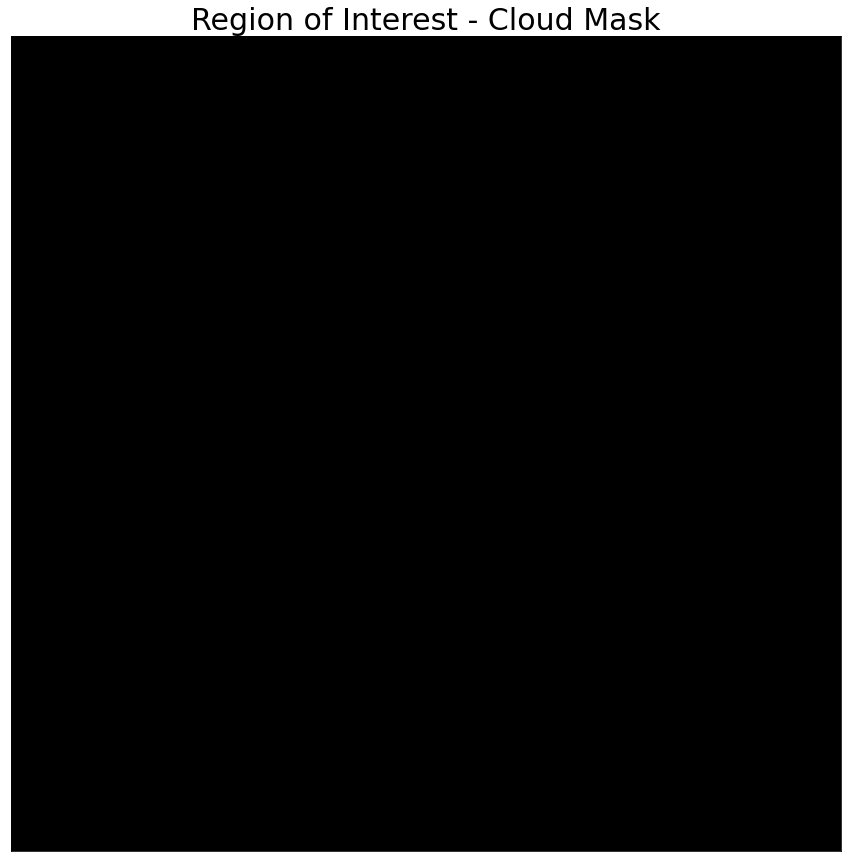

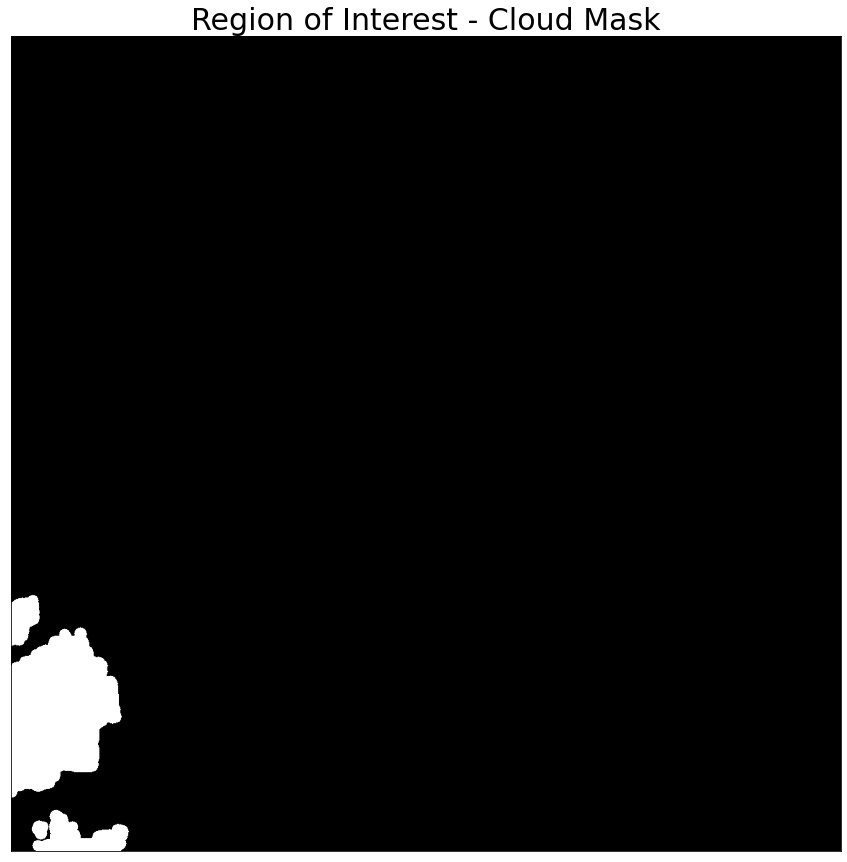

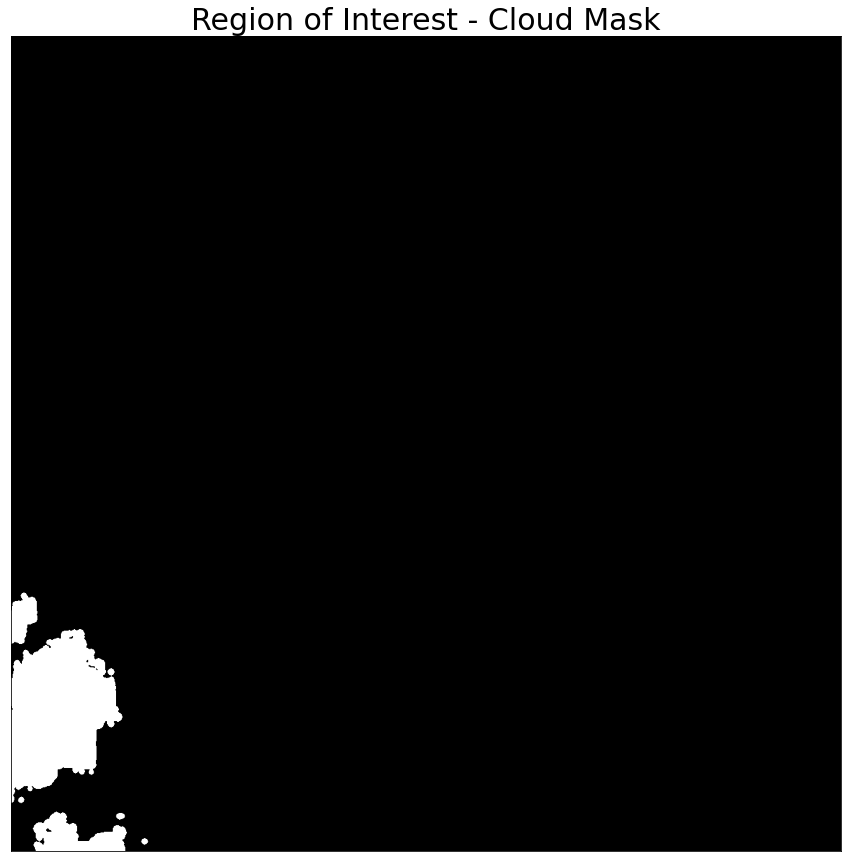

In [ ]:
param_tunning_automated(chosen_combinations)

In [ ]:
file_name = 'model_X.csv'
np.savetxt(file_name, cloud_mask, delimiter=',', fmt='%d')